In [5]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import seaborn as sns
import sklearn.metrics
import torch.nn.functional as F
from tqdm import tqdm
from pyro.distributions import constraints

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta",  dist.Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu",  dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z",  dist.Categorical(mix_weights(beta)))
        pyro.sample("obs",  dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta",  dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu",  dist.MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z",  dist.Categorical(phi))

In [108]:
data = torch.cat((dist.MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  dist.MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  dist.MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  dist.MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

N = data.shape[0]
T = 6
optim = pyro.optim.Adam({"lr": 0.05})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), 
                                              torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), 
                                              torch.mean(pyro.param("phi").detach(), dim=0))


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 207.65it/s]


In [109]:
print(Bayes_Weights_01)
print(Bayes_Weights_15) 

tensor([0.1664, 0.2679, 0.2491, 0.1858, 0.1308])
tensor([0.1080, 0.2047, 0.2165, 0.0504, 0.2044, 0.2161])


In [34]:
m_g = pd.read_csv("test_datasets/counts_sbs.N150.G3.csv")
m_sbs = m_g.drop(["groups"], axis=1)
g_sbs = m_g["groups"].tolist()
cosmic_sbs = pd.read_csv("test_datasets/COSMIC_filt.csv", index_col=0) 

In [ ]:
m_g = pd.read_csv("test_datasets/counts_dbs.N150.G3.csv")
m_dbs = m_g.drop(["groups"], axis=1)
g_dbs = m_g["groups"].tolist()
cosmic_dbs = pd.read_csv("test_datasets/COSMIC_dbs.csv", index_col=0) 

In [ ]:
dn_sbs = torch.tensor(cosmic_sbs.loc[["SBS6","SBS17b"]].values, dtype=torch.float64)
ref_sbs = torch.tensor(cosmic_sbs.loc[["SBS1","SBS2","SBS5"]].values, dtype=torch.float64)
# k_denovo = dn_sbs.shape[0]
# k_fixed = ref_sbs.shape[0]
clusters = 6

def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

conc = torch.tensor([0.36432, 0.383313626, 0.257168233, 0.005969330, 0.017175399])

pi_beta = torch.zeros(len(conc))
for i in range(len(conc)):
    pi_beta[i] = pyro.sample("beta", pyro.distributions.Beta(1, conc[i])) 

pi = mix_weights(pi_beta)

print(pi_beta)
print(torch.round(pi * 100))

with pyro.plate("beta_d_plate", len(conc)):
    pi_beta2 = pyro.sample("beta", pyro.distributions.Beta(1, conc)) 

print(pi_beta2)
pi2 = mix_weights(pi_beta2)
print(torch.round(pi2 * 100))

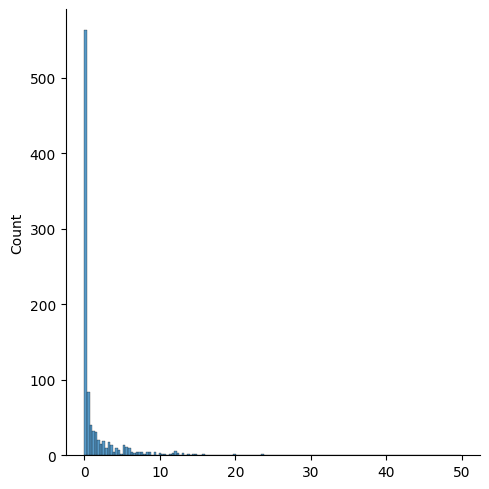

In [81]:
sns.displot(dist.Gamma(torch.tensor(0.2, dtype=torch.float64), 0.1).sample((1000,)).tolist())

In [70]:
torch.round(dist.Dirichlet(torch.tensor([0.3, 0.5, 0.3])*10).sample((10,)), decimals=3)


tensor([[0.3570, 0.6270, 0.0160],
        [0.3360, 0.5570, 0.1060],
        [0.3110, 0.4170, 0.2720],
        [0.3580, 0.5650, 0.0770],
        [0.1120, 0.6060, 0.2810],
        [0.4380, 0.4760, 0.0850],
        [0.3060, 0.3410, 0.3530],
        [0.2340, 0.3350, 0.4310],
        [0.2730, 0.4640, 0.2630],
        [0.2010, 0.7210, 0.0780]])

In [115]:
torch.mean(torch.tensor([1.,2.,3.]), dim=0)

tensor(2.)

In [129]:
obj_sbs = run.fit(
    x=m_sbs, 
    k_list=[3], 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=10, 
    cluster=6,
    dirichlet_prior=True,
    beta_fixed=cosmic_sbs.loc[["SBS1","SBS5"]], 
    store_parameters = True, 
    seed_list=[30],
    nonparametric=True,
    store_fits=True
    )


ELBO 409178.340557: 100%|██████████| 10/10 [00:00<00:00, 234.82it/s]


GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.0031], dtype=torch.float64)
GUIDE init_pi_conc0 tensor([22.0750,  2.6180,  0.9100,  3.0390,  1.2020], dtype=torch.float64)
GUIDE beta_pi tensor([0.0340, 0.1170, 0.7740, 0.0380, 0.0100, 0.0280], dtype=torch.float64,
       grad_fn=<RoundBackward1>)
GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.0031], dtype=torch.float64)
GUIDE init_pi_conc0 tensor([19.7930,  2.6110,  0.6580,  3.5580,  1.1650], dtype=torch.float64)
GUIDE beta_pi tensor([0.1140, 0.0710, 0.7160, 0.0170, 0.0340, 0.0480], dtype=torch.float64,
       grad_fn=<RoundBackward1>)


ELBO 97568.411243: 100%|██████████| 10/10 [00:00<00:00, 141.98it/s]

GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.0031], dtype=torch.float64)
GUIDE init_pi_conc0 tensor([20.9670,  2.7940,  0.7990,  3.0560,  1.2220], dtype=torch.float64)
GUIDE beta_pi tensor([0.0880, 0.4930, 0.1190, 0.0030, 0.1880, 0.1090], dtype=torch.float64,
       grad_fn=<RoundBackward1>)
GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.0031], dtype=torch.float64)
GUIDE init_pi_conc0 tensor([22.4140,  2.3480,  0.9440,  3.1560,  1.2710], dtype=torch.float64)
GUIDE beta_pi tensor([0.0030, 0.2000, 0.5810, 0.0080, 0.0210, 0.1870], dtype=torch.float64,
       grad_fn=<RoundBackward1>)
GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.0031], dtype=torch.float64)
GUIDE init_pi_conc0 tensor([21.6960,  2.5350,  0.9230,  3.0960,  1.2320], dtype=torch.float64)
GUIDE beta_pi tensor([0.0100, 0.1230, 0.1350, 0.1010, 0.4650, 0.1650], dtype=torch.float64,
       grad_fn=<RoundBackward1>)
GUIDE init_pi tensor([0.2165, 0.2481, 0.0803, 0.3260, 0.1259, 0.

In [331]:
obj_sbs.params["pi_conc0"] 

array([0.82374784, 0.39546498, 0.40519247, 0.64744787, 0.74957663])

In [316]:
obj_sbs.params["pi_conc0"] 

array([1.12026089, 0.83792458, 0.94909732, 0.86600618, 1.7188802 ])

In [319]:
obj_sbs.params["pi"] 

array([0.59300379, 0.17388244, 0.07029561, 0.11127863, 0.00519033,
       0.04634919])

In [333]:
np.round(obj_sbs.params["pi"], decimals=3)

array([0.767, 0.214, 0.019, 0.001, 0.   , 0.   ])

In [329]:
tmp = obj_sbs.params["pi"] ** 2
np.round(tmp / np.sum(tmp), decimals=3)

array([0.875, 0.074, 0.012, 0.032, 0.   , 0.007])

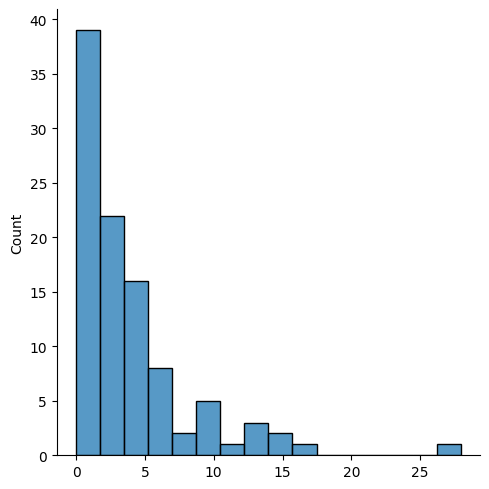

In [223]:
sns.displot(pyro.distributions.Gamma(0.5,0.1).sample((100,)).tolist())

In [ ]:
obj_sbs = run.fit(
    alpha=obj_sbs.params["alpha"],
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=100, 
    cluster=6,
    # hyperparameters={"penalty_scale":2},
    store_parameters = False, 
    seed_list=[30],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
obj_sbs.gradient_norms 

In [ ]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.regs) 

In [ ]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.likelihoods) 

In [ ]:
sns.pointplot(x=[_ for _ in range(100)], y=[obj_sbs.likelihoods[i]+obj_sbs.regs[i] for i in range(100)]) 

In [ ]:
sns.pointplot(x=[_ for _ in range(100)], y=obj_sbs.losses) 

In [ ]:
print(obj_sbs.init_params["beta_weights"])
print(obj_sbs.params["beta_w"]) 

In [ ]:
print(obj_sbs.init_params["beta_weights"])
print(obj_sbs.params["beta_w"]) 

In [ ]:
print(obj_sbs.params["alpha"])

In [ ]:
print(obj_sbs.params["alpha_star"])

In [ ]:
print(obj_sbs.params["alpha"])

In [ ]:
dn = torch.tensor(obj_sbs.params["beta_d"].values)
sbs1 = torch.tensor(cosmic_sbs.loc[["SBS1"]].values)
for i in range(dn.shape[0]):
    print(torch.nn.functional.cosine_similarity(sbs1, dn[i,:]))

In [ ]:
a_orig = pyro.distributions.Dirichlet(torch.tensor([1., 5.])).sample((100,)) 

In [ ]:
a = a_orig**3
fig, ax = plt.subplots()
sns.scatterplot(x=a[:,0].tolist(), y=a[:,1].tolist(), ax=ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1) 

In [ ]:
import numpy as np
from scipy.stats import dirichlet

# Define the parameters
alpha = [1, 1, 1]  # Adjust alpha values as needed
power = 2.0  # Adjust the power parameter

# Sample from the standard Dirichlet distribution
sample = np.random.dirichlet(alpha)

# Apply the transformation
sample_away_from_mode = sample ** (1 / power)

print("Sampled value away from the mode:", sample_away_from_mode)
print("Sampled:", sample)


In [ ]:
import torch
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Define the parameters of the Dirichlet distribution
alpha = torch.tensor([1.0, 5.0, 1.0])  # Replace with your alpha values

# Sample from the Dirichlet distribution
sampled_value = pyro.sample("sampled_value", dist.Dirichlet(alpha))

print("Sampled value away from the mode:", sampled_value)

# Find the mode of the Dirichlet distribution
mode = torch.argmax(alpha)

print("Mode", mode)

# Create a mask to zero out the mode value
mask = torch.ones_like(sampled_value)
mask[mode] = 0

# Zero out the mode value
sampled_value = sampled_value * mask

# Renormalize to make it a valid probability distribution
sampled_value = sampled_value / sampled_value.sum()

print("Sampled value away from the mode:", sampled_value)


In [ ]:
# a = a_orig**(3)
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
sns.histplot(a[:,0].tolist(), ax=ax2)
sns.histplot(a[:,1].tolist(), ax=ax3)
ax2.set_xlim(0,1)
ax3.set_xlim(0,1)

In [ ]:
torch.sum(fixed, dim=0)

In [ ]:
fixed = torch.tensor(obj_sbs.beta_fixed.values)
beta_w = torch.tensor(obj_sbs.params["beta_w"].values)
denovo = torch.tensor(obj_sbs.params["beta_d"].values)
cum_weights = torch.ones((obj_sbs.k_denovo, obj_sbs.k_fixed))/obj_sbs.k_fixed

fixed_cum = obj_sbs._get_unique_beta_stick_breaking(beta_fixed=fixed, beta_denovo=None, beta_weights=cum_weights)
fixed_cum = obj_sbs._norm_and_clamp(fixed_cum)

print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * torch.tensor(obj_sbs.x.values).sum())
print(torch.sum((fixed_cum * (torch.abs(fixed_cum - denovo)))) * obj_sbs.x.shape[0] * obj_sbs.x.shape[1])


In [ ]:
obj_sbs.losses

In [ ]:
len(obj_sbs.train_params)

In [ ]:
pyro.distributions.Dirichlet(fixed_cum*1000).log_prob(denovo) 

In [ ]:
obj_sbs.gradient_norms.keys()

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (1 - torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.x.sum() * torch.sum(beta_fixed_cum * (torch.abs(beta_fixed_cum - beta_denovo)))
obj_sbs.params["beta_w"] 

In [ ]:
## self.n_samples * self.contexts * pyro.distributions.Dirichlet(beta_fixed_cum*1000).to_event(1).log_prob(beta_denovo))
obj_sbs.params["beta_w"] 

In [ ]:
pyro.param("beta_weights")

In [ ]:
obj_sbs.params["beta_w"] 

In [ ]:
obj_sbs.gradient_norms.keys() 

In [ ]:
obj_sbs.params["alpha"].sum(axis=1)

In [ ]:
k_dn = 2
k_f = 3
n_samples = 5
beta_weights = pyro.distributions.Dirichlet(torch.ones(k_dn, k_f+1)).sample()
alpha_star = pyro.distributions.Dirichlet(torch.ones(n_samples, k_dn)).sample()
print("beta weights\n", beta_weights)
print("alpha star\n", alpha_star)

In [ ]:
beta_weights[1,2]

In [ ]:
alpha = torch.zeros((n_samples, k_dn+k_f))

for n in range(n_samples):
    for j in range(k_dn):
        for r in range(k_f):
            alpha[n, r] += torch.sum(alpha_star[n,j]) * beta_weights[j,r]
        
        for d in range(k_f, k_f+k_dn):
            alpha[n, d] += torch.sum(alpha_star[n,j]) * beta_weights[j,-1]

print(alpha)

In [ ]:
obj_sbs.params["beta_w"]

In [ ]:
obj_sbs.params["beta_d"]

In [ ]:
obj_dbs = run.fit(
    x=m_dbs, 
    k_list=3, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=10, 
    # cluster=6, 
    dirichlet_prior=True,
    beta_fixed=cosmic_dbs.loc[["DBS4"]], 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    enforce_sparsity = True, 
    reg_weight=0., 
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
alpha_sbs = obj_sbs.params["alpha"] 
alpha_dbs = obj_dbs.params["alpha"] 

In [ ]:
input = [alpha_sbs, alpha_dbs] 
input_tensor = [torch.tensor(alpha_sbs.values), torch.tensor(alpha_dbs.values)]
max_shape = max([i.shape[1] for i in input_tensor])
# stacked = torch.stack(input_tensor)

In [ ]:
mixture = run.fit(
    alpha=input, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=3000,
    cluster=5, 
    hyperparameters={"alpha_sigma":.15, "alpha_p_sigma":1., "alpha_p_conc0":0.6, 
                     "alpha_p_conc1":0.6, "alpha_rate":1., "pi_conc0":0.5, "alpha_conc":100,
                     "scale_factor_alpha":10000, "scale_factor_centroid":1000, "scale_tau":0},
    store_parameters = True, 
    seed_list=[92],
    nonparametric=True,
    store_fits=True
    )


In [ ]:
import torch.nn.functional as F
def mix_weights(beta):
    '''
    Function used for the stick-breaking process.
    '''
    print("beta =", beta)
    beta1m_cumprod = (1 - beta).cumprod(-1)
    print("beta1m_cumprod =", beta1m_cumprod)
    res1 = F.pad(beta, (0, 1), value=1)
    res2 = F.pad(beta1m_cumprod, (1, 0), value=1)
    res = res1 * res2
    print(f"res1 = {res1}, res2 = {res2}, res = {res}\n")
    return res


In [ ]:
cluster = 6
with pyro.plate("beta_plate", cluster-1):
    pi_beta = pyro.sample(f"beta", pyro.distributions.Beta(1, 1.1755e-36))
    # pi_beta = torch.tensor([1.1755e-36, 2.1648e-18, 1.1755e-36, 6.6389e-33, 1.1755e-36])
    print("pi_beta =", pi_beta)
    pi = mix_weights(pi_beta)

print(pi)

In [ ]:
beta_star = torch.zeros(k_denovo, 96, dtype=torch.float64) 
for i in range(k_denovo):
    tmp_sbs = torch.cat((ref_sbs, dn_sbs[i].unsqueeze(0)))
    beta_star[i] = pi[i].unsqueeze(0).matmul(tmp_sbs) 

In [ ]:
pyro.distributions.Gamma(0.01, 0.01).sample((5,))

In [ ]:
pyro.distributions.Dirichlet(torch.ones(5)).sample()

In [ ]:
(1 - pyro.distributions.Beta(1, 1e-10).sample((cluster-1,))).cumprod(-1)

In [ ]:
pi = torch.zeros((10,))
pi[:5] = 5
pi 

In [ ]:
alpha_centr = mixture[0].params["alpha_prior"]
print(alpha_centr) 

In [ ]:
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_sbs)) 
print(sklearn.metrics.normalized_mutual_info_score(mixture.groups, g_dbs)) 

In [ ]:
print(obj_sbs.params["scale_factor_centroid"])
print(obj_sbs.params["scale_factor_alpha"]) 

In [ ]:
obj_sbs.params

In [ ]:
obj_sbs.train_params[6]["scale_factor_centroid"]

In [ ]:
obj_sbs.params["pi_conc0"] 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.likelihoods)), y=obj_sbs.likelihoods) 

In [ ]:
sns.scatterplot(x=range(len(obj_sbs.losses)), y=obj_sbs.losses) 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_centroid_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_centroid_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["scale_factor_alpha_param"])), 
                     y=obj_sbs.gradient_norms["scale_factor_alpha_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha_prior_param"])), y=obj_sbs.gradient_norms["alpha_prior_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_param"])), y=obj_sbs.gradient_norms["pi_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["pi_conc0_param"])), y=obj_sbs.gradient_norms["pi_conc0_param"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["alpha"])), y=obj_sbs.gradient_norms["alpha"]) 
except: print() 

In [ ]:
try: sns.scatterplot(x=range(len(obj_sbs.gradient_norms["beta_denovo"])), y=obj_sbs.gradient_norms["beta_denovo"])
except: print()

In [ ]:
pd.DataFrame(np.array(obj_sbs.init_params["alpha_prior_param"]), columns=obj_sbs.params["alpha"].columns).plot.bar(stacked=True, legend=False) 

In [ ]:
try: pd.DataFrame(np.array(obj_sbs.params["alpha_prior"]), columns=obj_sbs.params["alpha_prior"].columns).plot.bar(stacked=True, legend=False) 
except Exception as e: print() 

In [ ]:
try:
    for gid in set(np.array(obj_sbs.groups)):
        tmp = [i for i, v in enumerate(obj_sbs.groups) if v == gid]
        # tmp = [i for i, v in enumerate(obj_sbs.groups) if (v == gid and i in idxs)]
        if len(tmp) == 0: continue
        pd.DataFrame(np.array(obj_sbs.params["alpha"]), columns=obj_sbs.params["alpha"].columns, 
                     index=obj_sbs.params["alpha"].index).iloc[tmp].plot.bar(stacked=True)
except Exception as e:
    print(e)
    obj_sbs.alpha.plot.bar(stacked=True, legend=False) 


In [ ]:
try:
    for sbs in pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).index:
        pd.concat((obj_sbs.params["beta_f"], obj_sbs.params["beta_d"])).loc[[sbs]].transpose().plot.bar()
except Exception as e:
    print(e)